In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from math import sqrt, pi, exp, erf
from scipy.special import erfinv
from numpy import vectorize

In [2]:
%matplotlib notebook

In [3]:
# Boundaries of x0 grid
bounds_x0 = (-1, 1)

# Number of X0/C grid points
Nx0 = 1000

# The x0 grid interval
dx0 = (bounds_x0[1] - bounds_x0[0])/Nx0

# Boundaries of t grid
bounds_t = (0, 10)

# Initial Probability Distribution Variables
mu = 0
sigma = 1

# Constants of the experiment
h = 1
mass = 1
gamma = h*h/(2*mass)

# Initial kinetic energy (used to determine velocity)
K0 = 1

In [5]:
kernel_size = 9
# Utility function to generate gradient matrices
def grad_matrix(forward, central, inv):
    offset = kernel_size//2
    backward = [-x if inv else x for x in reversed(forward)]
    mat = np.zeros((Nx0, Nx0), dtype = np.longdouble)
    mat[0][0:kernel_size] = forward
    mat[-1][-kernel_size:] = backward
    for i in range(1, offset):
        mat[i][i:i+kernel_size] = forward
        mat[-(i+1)][-(kernel_size+i):-i] = backward
    for i in range(offset, Nx0-(offset)):
        mat[i][i-(offset):i-offset+kernel_size] = central
    
    return mat

# Create spatial gradient operators (1st to 2nd order)
derive_1 = 1/(840*dx0) * grad_matrix([-2283, 6720, -11760, 15680, -14700, 9408, -3920, 960, -105], [3, -32, 168, -672, 0, 672, -168, 32, -3], True)
derive_2 = 1/(5040*(dx0**2)) * grad_matrix([29531, -138528, 312984, -448672, 435330, -284256, 120008, -29664, 3267], [-9, 128, -1008, 8064, -14350, 8064, -1008, 128, -9], False)
#derive_1 = 1/(dx0) * grad_matrix([-1171733, 5045040, -16396380, 43723680, -90180090, 144288144, -180360180, 176679360, -135270135, 80160080, -36072036, 11924640, -2732730, 388080, -25740], [-67553994410557440, 1103381908705771400, -8606378887905023000, 43031894439525040000, -157783612944925300000, 473350838834776100000, -1.4200525165043277e+21, -45045, 1.4200525165043282e+21, -473350838834776000000, 157783612944925330000, -43031894439525120000, 8606378887905019000, -1103381908705771500, 67553994410557440], True, 360360, 1.622917161719232e+21)
#derive_2 = 1/(dx0**2) * grad_matrix([45136007302431600000, -316288755575409600000, 1.2562107187266613e+21, -3.5528039282546253e+21, 7.536907676540124e+21, -1.2259931873997893e+22, 1.5492314502108977e+22, -1.5293275775555057e+22, 1.177617305746773e+22, -7.009472859908935e+21, 3.1654227642664737e+21, -1.0494392247242149e+21, 241072934108155280000, -34304477446737584000, 2279234942751072300, ], [900, -17150, 160524, -1003275, 4904900, -22072050, 132432300, -228812298, 132432300, -22072050, 4904900, -1003275, 160524, -17150, 900], False, 5016972815530276000, 75675600)


In [9]:
# Coefficient to obtain truncated Gaussian
k = 0.5 * (erf((bounds_x0[1])/(sigma*sqrt(2))) - erf((bounds_x0[0])/(sigma*sqrt(2))))

# Computes a truncated Gaussian w.r.t bounds_x0, sigma, and mu.
def gaussian(x):
    return 1/(k*sigma*sqrt(2*pi)) * exp(-0.5*((x-mu)/sigma)**2) if bounds_x0[0] <= x <= bounds_x0[1] else 0

# Computes the classical potential
def potential(q):
    return 0

# Computes the classical force (-grad(V))
def force(q):
    return 0

def C(x0):
    return 0.5 * (1 + erf((x0-mu)/(sigma * sqrt(2))))

def X0(c):
    return mu + (sigma*sqrt(2)) * erfinv(2*c-1)

def test_func(c):
    return abs( (c-a)**3 * (b-x) )

# Computes the initial quantum potential
def initial_quantum_potential(q):
    return -gamma * ratio2(q)

# Computes the initial quantum force
def initial_quantum_force(q):
    return -gamma  * -(q-mu)/(2*(sigma**4))

# Computes the initial acceleration for a particle at x
def initial_acceleration(q):
    return 1/mass * (force(q) + initial_quantum_force(q))

In [10]:
# Utility lambda to apply functions to a set of X values
_gaussian = vectorize(gaussian)
_potential = vectorize(potential)
_force = vectorize(force)
_initial_quantum_potential = vectorize(initial_quantum_potential)
_initial_quantum_force = vectorize(initial_quantum_force)
_initial_acceleration = vectorize(initial_acceleration)
_C = vectorize(C)

<IPython.core.display.Javascript object>


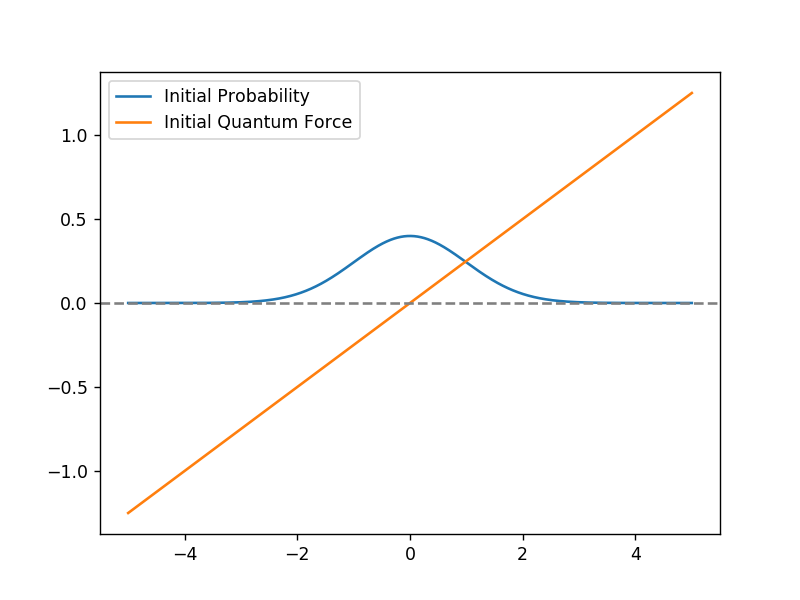

In [11]:
x_plot = np.linspace(-5, 5, 1000)
fig1 = plt.figure()
plt.plot(x_plot, _gaussian(x_plot), label="Initial Probability")
plt.plot(x_plot, _initial_quantum_force(x_plot), label="Initial Quantum Force")

plt.axhline(linestyle="--", color="gray")
plt.legend()
fig1.show()

In [12]:
def ode_derive(t, y):
    pos = y[0:Nx0]
    vel = y[Nx0:2*Nx0]
    
    if t == 0:
        return np.concatenate((vel, _initial_acceleration(pos)))
    
    der1 = derive_1 @ pos
    der2 = derive_2 @ pos
    
    acc = 1/mass * (
                  _force(pos)
                + 0.5 * gamma * (
                    
                    
                    - 2.5*(der2**3)/(der1**2) 
                    + 2*der2*der3/der1 
                    - der4)))
    
    return np.concatenate((vel, acc))

x0 = np.linspace(bounds_x0[0], bounds_x0[1], Nx0, dtype=np.longdouble)
C0 = _C(x0)
v0 = np.full((Nx0), sqrt(2*K0/mass), dtype=np.longdouble)
y0 = np.concatenate((x0, v0))

result = solve_ivp(ode_derive, (0, 1), y0)

NameError: name 'x' is not defined

In [ ]:
fig2 = plt.figure()
for i in range(0, 100):
    plt.plot(result.y[10*i], result.t)

fig2.show()

In [ ]:
N=50
fig3=plt.figure()
for i in range(1, 100):
    plt.plot(result.y[(Nx0+10*i)][:-N], result.t[:-N])

plt.xlim(-50, 100)
fig3.show()

In [ ]:
idx=len(result.t)-N
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, Nx0)
yt = np.transpose(result.y)
pos = yt[0][0:Nx0]
vel = yt[0][Nx0:2*Nx0]

der1 = derive_1 @ pos
der2 = derive_2 @ pos
der3 = derive_3 @ pos
der4 = derive_4 @ pos

line, = ax.plot(x_plot, derive_3 @ yt[0][0:Nx0])
plt.ylim(np.min(-30), np.max(30))

def animate(i):
    d = derive_3 @ yt[i][0:Nx0]
    line.set_ydata(d)  # update the data
    return line,

def init():
    return animate(0)

ani = animation.FuncAnimation(fig, animate, np.arange(0, len(result.t)-N), init_func=init,
                              interval=100, blit=True)